In [1]:
%load_ext autoreload
%autoreload 2

#%pylab notebook
%matplotlib inline
from pylab import *
from matplotlib import rc;rc('text', usetex=True);rc('font', weight='bold');matplotlib.rcParams['text.latex.preamble'] = r'\boldmath'
import os
rc('text.latex',preamble=r'\usepackage{/Users/sraghunathan/.configs/apjfonts}')

In [2]:
rcParams['figure.dpi'] = 150
rcParams['font.family'] = 'serif'
rcParams["figure.facecolor"] = 'white'

In [3]:
import argparse, sys, numpy as np, scipy as sc, warnings, os
sys.path.append('/Users/sraghunathan/Research/SPTPol/analysis/git/DRAFT/modules/')
import flatsky, misc, exp_specs
import ilc, foregrounds as fg

#import matplotlib.cbook
warnings.filterwarnings('ignore',category=RuntimeWarning)
#warnings.filterwarnings('ignore', category=DeprecationWarning)
#warnings.filterwarnings('ignore', category=matplotlib.cbook.mplDeprecation)

In [4]:
#some constants
h=6.62607004e-34 #Planck constant in m2 kg / s
k_B=1.38064852e-23 #Boltzmann constant in m2 kg s-2 / K-1
Tcmb = 2.73 #Kelvin

In [5]:
paramfile = 'params.ini'

include_gal = 1
# read and store param dict
param_dict = misc.fn_get_param_dict(paramfile)
param_dict['lmax'] = 5000
el = np.arange(param_dict['lmax'])


In [6]:
if (0):
    which_gal_mask = 2 ##5
    fd = 'results/20200701/s4like_mask_v2/TT-EE/baseline/'
    fname = '%s/s4wide_ilc_galaxy1_27-39-93-145-225-278_TT-EE_galmask%s_AZ.npy' %(fd, which_gal_mask)
if (1):
    which_gal_mask = 1 ##5
    fd = 'results/20200701/s4like_mask_v3/TT-EE/baseline/'
    fname = '%s/s4wide_ilc_galaxy1_27-39-93-145-225-278_TT-EE_galmask%s_AZ.npy' %(fd, which_gal_mask)
param_dict['which_gal_mask'] = which_gal_mask
opfname = fname.replace('.npy', '_galresiduals.npy')

In [9]:
#read ILC file to get weights
ilc_res_dic = np.load(fname, allow_pickle=1, encoding = 'latin1').item()
print(ilc_res_dic.keys(), ilc_res_dic['which_gal_mask'])
cl_residual = ilc_res_dic['cl_residual']
weights_dic = ilc_res_dic['weights']
which_spec_arr = list(weights_dic.keys())
beam_noise_dic = ilc_res_dic['beam_noise_dic']
freqarr = sorted(list(ilc_res_dic['beam_noise_dic']['T'].keys()))
print(weights_dic.keys())
print(freqarr)

dict_keys(['el', 'cl_residual', 'freqcalib_fac', 'param_dict', 'fsky_val', 'which_gal_mask', 'weights', 'beam_noise_dic', 'elknee_dic']) 1
dict_keys(['TT', 'EE'])
[27, 39, 93, 145, 225, 278]


In [10]:
#get beams
bl_dic = misc.get_beam_dic(freqarr, beam_noise_dic['T'], param_dict['lmax'])
print(bl_dic.keys())
if (0):
    for freq in freqarr:
        plot(bl_dic[freq], label = freq)
    legend(loc = 1)

dict_keys([27, 39, 93, 145, 225, 278])


In [11]:
#get galactic cl
cl_gal_dust_dic, cl_gal_sync_dic = {}, {}
for which_spec in which_spec_arr:
    cl_gal_dust_dic[which_spec], cl_gal_sync_dic[which_spec] = {}, {}
    for freq1 in freqarr:
        for freq2 in freqarr:
            el_, cl_gal_dust = fg.get_cl_galactic(param_dict, 'dust', freq1, freq2, which_spec, el = el, bl_dic = bl_dic)
            el_, cl_gal_sync = fg.get_cl_galactic(param_dict, 'sync', freq1, freq2, which_spec, el = el, bl_dic = bl_dic)
            cl_gal_dust_dic[which_spec][(freq1, freq2)] = cl_gal_dust
            cl_gal_sync_dic[which_spec][(freq1, freq2)] = cl_gal_sync


In [12]:
#residual dic
fg_res_dic = {}
signal_arr = ['gal_dust', 'gal_sync']
for which_spec in which_spec_arr:
    fg_res_dic[which_spec] = {}
    for elcnt, currel in enumerate(el):
        #if (elcnt%1000) == 0: print(which_spec, elcnt)
        for s in signal_arr:
            if s == 'gal_dust':
                curr_cl_dic = cl_gal_dust_dic[which_spec]
            elif s == 'gal_sync':
                curr_cl_dic = cl_gal_sync_dic[which_spec]

            ###from IPython import embed; embed()
            clmat = np.mat( ilc.create_clmat(freqarr, elcnt, curr_cl_dic) )
            currw_ilc = np.mat( weights_dic[which_spec][:, elcnt] )
            curr_res_ilc = np.asarray(np.dot(currw_ilc, np.dot(clmat, currw_ilc.T)))[0][0]
            if s not in fg_res_dic[which_spec]:
                fg_res_dic[which_spec][s] = []
            fg_res_dic[which_spec][s].append( curr_res_ilc )
    
    for s in signal_arr:
        fg_res_dic[which_spec][s] = np.asarray(fg_res_dic[which_spec][s])
print(fg_res_dic.keys())      
print(fg_res_dic['TT'].keys())
#print(fg_res_dic['TT']['gal_dust'][:10])
#print(fg_res_dic['TT']['gal_sync'][:10])
np.save(opfname, fg_res_dic)
print(opfname)

dict_keys(['TT', 'EE'])
dict_keys(['gal_dust', 'gal_sync'])
results/20200701/s4like_mask_v3/TT-EE/baseline//s4wide_ilc_galaxy1_27-39-93-145-225-278_TT-EE_galmask1_AZ_galresiduals.npy


In [13]:
colordic = {}
dummy_freqarr = [20, 27, 39, 93, 145, 225, 278, 350]
colorarr = [cm.jet(int(d)) for d in np.linspace(0, 255, len(dummy_freqarr) )]
for fcntr, f in enumerate( dummy_freqarr ):
    colordic[f] = colorarr[fcntr]
colordic[27] = 'navy'
colordic[39] = 'royalblue'
colordic[93] = 'lightseagreen'
colordic[145] = 'darkgreen'

<Figure size 900x600 with 0 Axes>

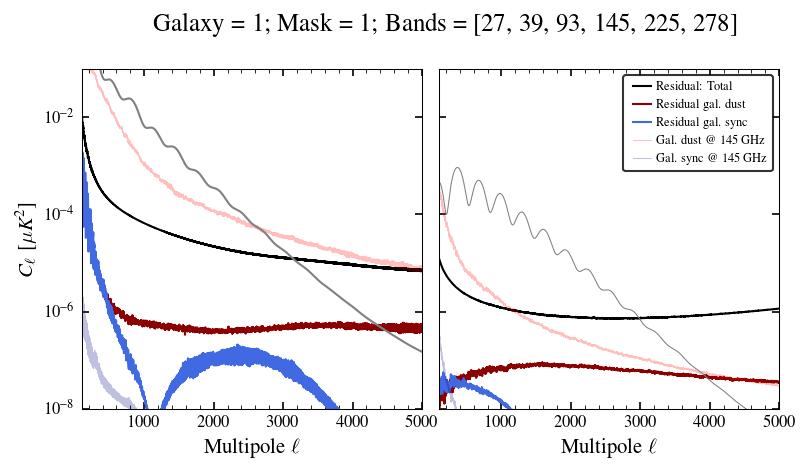

In [14]:
freq0, lmax = param_dict['freq0'], param_dict['lmax']

#CAMB output for plotting
#camb_file = param_dict['Dlfile_len']
camb_file = '%s/%s' %(param_dict['data_folder'], param_dict['Dlfile_len'])
el_camb = np.loadtxt(camb_file, usecols = [0])
dl_camb = np.loadtxt(camb_file, usecols = [1,2,3,4])

cl_camb = ( Tcmb**2. * dl_camb * 2 * np.pi ) / ( el_camb[:,None] * (el_camb[:,None] + 1) )
cl_camb *= 1e12
cl_TT, cl_EE, cl_BB, cl_TE = cl_camb.T

clf(); 
fig = figure(figsize = (6,3))
subplots_adjust(wspace = 0.05)
fsval = 8
lwval = 0.75
xmin, xmax = 100, 5000

for cntr, which_spec in enumerate( which_spec_arr ):
    ax = subplot(1, len(which_spec_arr), cntr+1, yscale = 'log')#, xscale = 'log')
    plot(el, cl_residual[which_spec][el], 'black', lw = 1., label = r'Residual: Total')

    #now plot residual gal_dust and gal_sync
    plot(el, fg_res_dic[which_spec]['gal_dust'], 'darkred', lw = 1., label = r'Residual gal. dust')
    plot(el, fg_res_dic[which_spec]['gal_sync'], 'royalblue', lw = 1., label = r'Residual gal. sync')
    
    plot(el, cl_gal_dust_dic[which_spec][(145,145)], 'red', lw = 0.5, alpha = 0.25, label = r'Gal. dust @ 145 GHz')
    plot(el, cl_gal_sync_dic[which_spec][(145,145)], 'navy', lw = 0.5, alpha = 0.25, label = r'Gal. sync @ 145 GHz')    
    
    if which_spec == 'TT':
        plot(el_camb, cl_TT, 'gray', lw = 1., label = r'TT')
    elif which_spec == 'EE':
        plot(el_camb, cl_EE, 'gray', lw = 0.5)#, label = r'EE')
    

    xlim(xmin, xmax);
    ylim(1e-8,1e-1);
    xlabel(r'Multipole $\ell$')
    if cntr == 0: 
        ylabel(r'$C_{\ell}$ $[\mu K^{2}]$')
    else:
        legend(loc = 1, fontsize = 6, ncol = 1, handlelength = 2., handletextpad = 0.1)
        setp(ax.get_yticklabels(which = 'both'), visible=False)
    for label in ax.get_xticklabels(): label.set_fontsize(fsval)
    for label in ax.get_yticklabels(): label.set_fontsize(fsval)
        
tit = 'Galaxy = %s; Mask = %s; Bands = %s' %(include_gal, which_gal_mask, str(freqarr))    
suptitle(r'%s' %tit, x = 0.53, y = 1.)
show()


In [22]:
#plot all mask residuals
import glob
fd = '/'.join(opfname.split('/')[:-1])
flist = sorted( glob.glob('%s/*galres*' %(fd)) )
fg_dic = {}
for f in flist:
    galmask = int(f.split('/')[-1].split('_')[5].replace('galmask', ''))
    resdic = np.load(f, allow_pickle=1).item()
    fg_dic[galmask] = resdic
    print(galmask)

0
1
2


<Figure size 900x600 with 0 Axes>

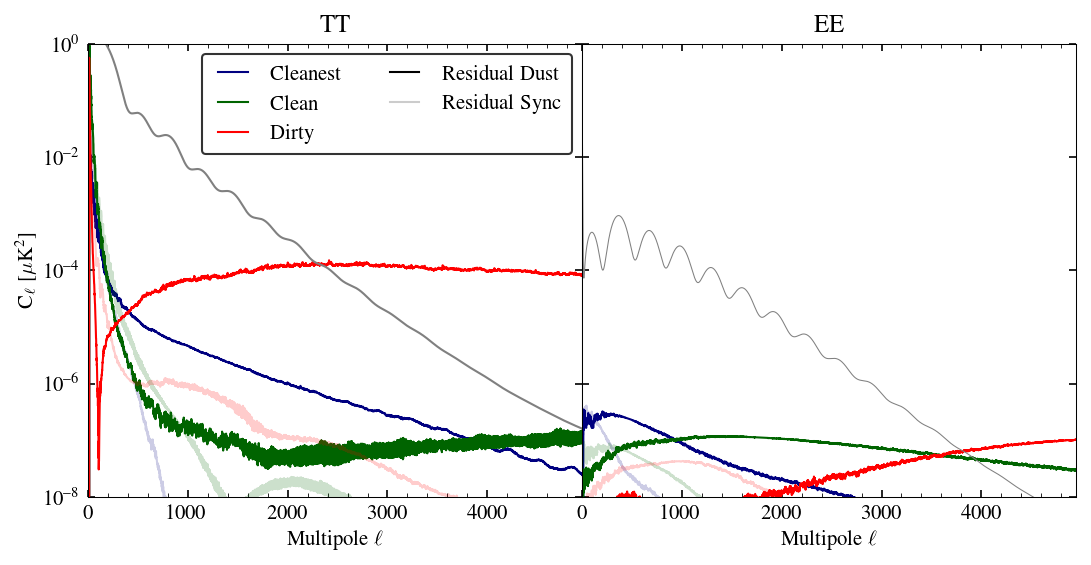

In [47]:
clf()
figure(figsize=(8.5, 4.))
subplots_adjust(wspace = 0.)
which_spec_arr = ['TT', 'EE']
galmask_str_dic = {0: ['Cleanest', 'navy'], 1: ['Clean', 'darkgreen'], 2: ['Dirty', 'red']}
lwval = 1.
syncalpha = 0.2
for cntr, which_spec in enumerate( which_spec_arr ):
    ax = subplot(1, len(which_spec_arr), cntr+1, yscale = 'log')#, xscale = 'log')
    for galmask in sorted(fg_dic):        
        #now plot residual gal_dust and gal_sync
        res_dust = fg_dic[galmask][which_spec]['gal_dust']
        res_sync = fg_dic[galmask][which_spec]['gal_sync']
        labval = None
        if which_spec == 'TT':
            labval = r'%s' %(galmask_str_dic[galmask][0])
            ylabel(r'C$_{\ell}$ [$\mu$K$^{2}$]')
        plot(el, res_dust, color = galmask_str_dic[galmask][1], lw = lwval, label = labval)
        plot(el, res_sync, color = galmask_str_dic[galmask][1], lw = lwval, alpha = syncalpha)

    if which_spec == 'TT':
        plot(el_camb, cl_TT, 'gray', lw = 1.)
        plot([], [], 'k-', label = r'Residual Dust', lw = lwval)
        plot([], [], 'k-', label = r'Residual Sync', lw = lwval, alpha = syncalpha)
        legend(loc = 1, fontsize = 10, ncol = 2)
    elif which_spec == 'EE':
        plot(el_camb, cl_EE, 'gray', lw = 0.5)#, label = r'EE')
        setp(ax.get_yticklabels(), visible=False)
    

    title(r'%s' %(which_spec))
    ylim(1e-8, 1.)
    xlim(0, 4950)
    xlabel(r'Multipole $\ell$')

    